## Importing Libraries

In [1]:
import string
import re
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import unicodedata
import wordcloud

from tensorflow.keras import optimizers, models
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Dropout, Attention, GRU, SimpleRNN, Layer, concatenate
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# libraries for base machine learning models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay 

## Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Reading the training data from the csv
df = pd.read_csv("/content/drive/MyDrive/Amazon_Reviews.csv", index_col=0)

In [4]:
#Finding the number of dimensions of the data
df.shape

(200000, 4)

In [5]:
df.columns

Index(['reviewText', 'sentiment', 'length_reviews', 'Category'], dtype='object')

In [6]:
#Checking if there are any null values
df.isna().sum()

reviewText        78
sentiment          0
length_reviews     0
Category           0
dtype: int64

In [14]:
#Removing the records with null values
df.dropna(subset=['reviewText'], inplace=True)

In [8]:
#Checking the number of values for each class to identify if there is any significant data imbalance
df['sentiment'].value_counts()

positive    99966
negative    99956
Name: sentiment, dtype: int64

In [9]:
#Label encoding 
lb = LabelEncoder()
df['Category'] = lb.fit_transform(df['Category'])
df['sentiment'] = lb.fit_transform(df['sentiment'])

## Text Pre processing

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
#function to replace all short abbrevations in the data with expanded equivalent
def expand_words(x):
	contractions = {"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how does","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not"," u ": " you "," ur ": " your "," n ": " and ","won't": "would not","dis ": "this","bak": "back","brng": "bring"
	}

	if type(x) is str:
		for key in contractions:
			value = contractions[key]
			x = x.replace(key, value)
		return x
	else:
		return x

In [12]:
#Other text pre processing functions like removing stopwords, special characters, digits etc.
def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

def remove_special_characters(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = x.replace("_", "")
	x = ' '.join(x.split())
	return x

def remove_digits(x):
	x = re.sub(r'[\d+]', "", x)
	x = ' '.join(x.split())
	return x

def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

def Lemmatization(x):
    x = str(x)
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

In [ ]:
#Applying all the text pre-processing to the training data
df['reviewText'] = df['reviewText'].apply(lambda x: str(x).lower())
df['reviewText'] = df['reviewText'].apply(lambda x: expand_words(x))
df['reviewText'] = df['reviewText'].apply(lambda x: remove_special_characters(x))
df['reviewText'] = df['reviewText'].apply(lambda x: remove_accented_chars(x))
df['reviewText'] = df['reviewText'].apply(lambda x: remove_stopwords(x))
df['reviewText'] = df['reviewText'].apply(lambda x: Lemmatization(x))
df['reviewText'] = df['reviewText'].apply(lambda x: remove_digits(str(x)))

In [13]:
df = pd.read_csv("/content/drive/MyDrive/Amazon_Reviews_preprocessed.csv", index_col=0)

In [15]:
pd.set_option('display.max_colwidth', -1)
df[['reviewText', 'sentiment', 'Category']].sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,reviewText,sentiment,Category
95763,bring knife friend like heavy sharp handle metal great gripping,0,3
126892,washed pajama wear wash look wash time pajama look old thread come initial wash great quality recommend buying product,0,2
44638,picture cable look stereo send mono cable course want song stereo like beatle s quality sound expect,0,1
39636,reminds go barber shop dadand feel barber finish,1,0
178084,year old son wanting month finally get birthday problem way sensitive half time soon try piece buck get old pretty quickly jump laugh would not recommend,0,4
76601,cheap cable own year kick away make life work seamlessly buy need,1,1
195140,cute book story outfit year old daughter super excited elf visit birthday,1,4
177164,toy worth money interactivity toy look like lot thing push misleading interactivity rotate little ball shape rest movable part walker push probably good toy son prefer little tike push ride racer item interest worth money kid different,0,4
74515,mother use vcr have hard time find vhs tape turn amazon find great price day thrill ordering need,1,1
193436,great kid help track reading time,1,4


In [16]:
#filtering reviews less than or equal to 50 words.

df = df[(df['reviewText'].apply(lambda x:len(x.split(" ")))) <=50]
df.shape

(199671, 4)

In [ ]:
df.sample(10)

,reviewText,sentiment,length_reviews,Category
78073,use mobile unit contact mountain rock hound use mobile base unit,1,30,1
68036,transcriber work great price learn medical transcription transcriber get job anticipate get different,1,37,1
37036,suave good value quality product use strawberry shampoo suave strawberry conditioner hair smell luscious people tell try brand suave,1,43,0
139276,read review shirt fit small right wish take heed material look great small matter,0,39,2
167084,followed instruction sheet 4 test flight thing spin spin fall sidea total thissappointmentmay defective knowsi recharge 14 hoursnothe change battery nothingdo buyif hate thing consistent,0,55,4
115579,find old hoover brushvac hand vacuum local thrift store couple buck belt replacement problem luckily find amazon vacuum away,1,38,3
127381,picture cheaply stiff functional gift embarrass,0,26,2
179020,guess hit miss toy thisplay screen say cb open check coin bank door rechecke firmly shut button work open button return look like lot fun work,0,65,4
138412,dress light crinkle cotton old heavy barkcloth popular slipcover 1940s 50sthe dress stiff hard soft washed shrank size ok enormous begin purchase mistake want add price send prob wear,0,83,2
69250,nice filter work protect expensive lens intact protect worth keep camera bag knock ultra violet ray,1,31,1


In [ ]:
df.dtypes

reviewText        object
sentiment         int64 
length_reviews    int64 
Category          int64 
dtype: object

## Visualizing common words

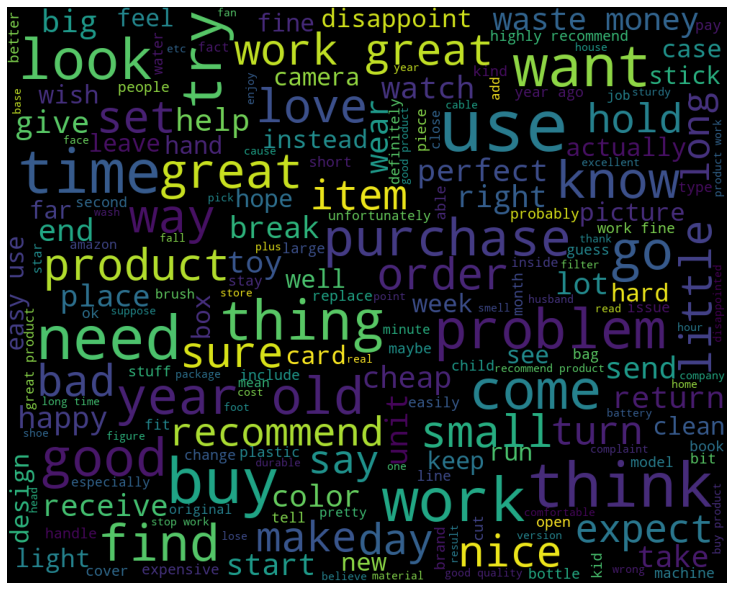

In [17]:
# Wordcloud For all the reviews
from wordcloud import WordCloud
word_cloud_df = df
all_words = ' '.join([text for text in word_cloud_df['reviewText']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

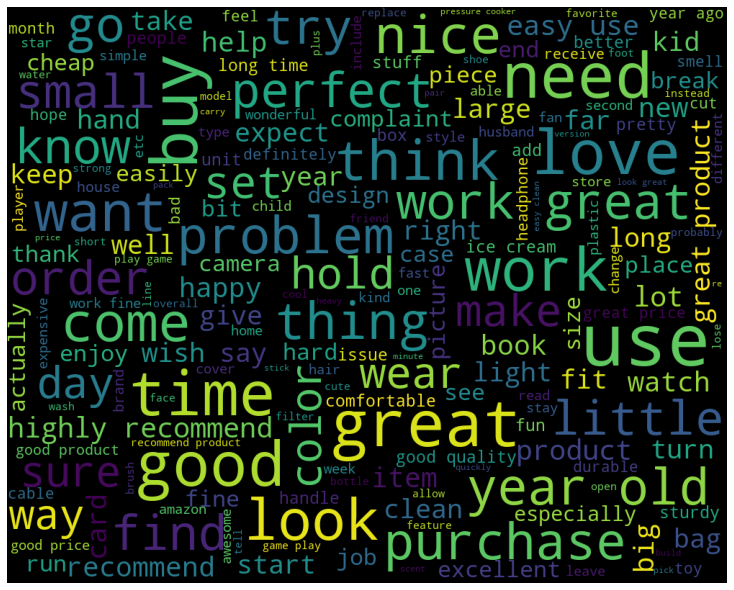

In [18]:
# Wordcloud for positive reviews
from wordcloud import WordCloud
word_cloud_df = df[df['sentiment'] == 1]
all_words = ' '.join([text for text in word_cloud_df['reviewText']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

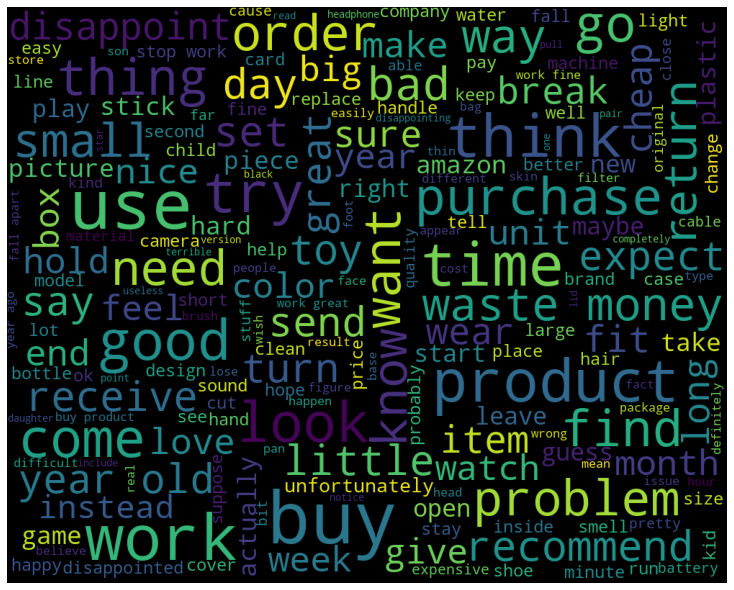

In [19]:
# Wordcloud for negative reviews
from wordcloud import WordCloud
word_cloud_df = df[df['sentiment'] == 0]
all_words = ' '.join([text for text in word_cloud_df['reviewText']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Data Splitting

In [20]:
#defining X and y
X = df[['reviewText', 'Category']]
y = df['sentiment']

In [21]:
X.shape, y.shape

((199671, 2), (199671,))

In [22]:
#Splitting the data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 100, stratify = y)

In [23]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((159736, 2), (39935, 2), (159736,), (39935,))

## Tokenization


In [24]:
#defining the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['reviewText'].astype("str"))

In [25]:
#Finding the total vocab size of the training data
tokenizer_vocab_size = len(tokenizer.word_index) + 1
print('Review Vocabulary Size: %d' % tokenizer_vocab_size)

Review Vocabulary Size: 118749


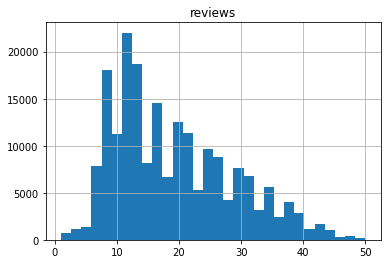

In [26]:
# hist to visualise the length of reviews
reviews = []
# populate the lists with sentence lengths
for i in df['reviewText']:
  reviews.append(len(str(i).split()))

length_df = pd.DataFrame({'reviews':reviews})

length_df.hist(bins = 30)
plt.show()

In [27]:
maxlen = 50
print(maxlen)

50


In [28]:
#Converting the training and validation data to numeric vectors and adding padding at the end.
X_train_seq = tokenizer.texts_to_sequences(X_train['reviewText'].astype("str"))
X_train_pad = pad_sequences(X_train_seq, maxlen=int(maxlen), padding='post')

X_valid_seq = tokenizer.texts_to_sequences(X_valid['reviewText'].astype("str"))
X_valid_pad = pad_sequences(X_valid_seq, maxlen=int(maxlen), padding='post')

In [29]:
X_train_pad.shape, X_valid_pad.shape, y_train.shape, y_valid.shape

((159736, 50), (39935, 50), (159736,), (39935,))

In [30]:
y_train1 = y_train
y_valid1 = y_valid

In [31]:
y_train=pd.get_dummies(y_train)
y_valid=pd.get_dummies(y_valid)

In [32]:
y_train.value_counts()

0  1
0  1    79874
1  0    79862
dtype: int64

## Word Embedding

In [33]:
#Implementing word embedding technique - 300 dimension glove to generate dense word vectors 
!pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [34]:
vector_size = 300
gensim_weight_matrix = np.zeros((tokenizer_vocab_size ,vector_size))
gensim_weight_matrix.shape

(118749, 300)

In [35]:
for word, index in tokenizer.word_index.items():
    if index < tokenizer_vocab_size: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


## Model building & Training

In [36]:
#Embedding layer using word embedding weights
embedding_layer = tf.keras.layers.Embedding(tokenizer_vocab_size, 300, weights=[gensim_weight_matrix], input_length=X_train_pad.shape[1],trainable=False)

In [37]:
#Early stopping the model training based on validation loss
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

In [38]:
#Attention layer definition
class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.W1(values) + self.W2(hidden_with_time_axis)
        score = self.V(tf.nn.tanh(score))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({"units": self.units})
        return config

## BiRNN

In [39]:
# Defining and embedding the inputs - ReviewText and category
sequence_input = Input(shape=(maxlen,), dtype='int32')
prod_category = Input(shape=(1,))

embedding_reviews = embedding_layer(sequence_input)
embedding_category = embedding_layer(prod_category)

# BiRNN layer & Dense layers with dropout for regularization
x = Bidirectional(SimpleRNN(256, dropout=0.2))(embedding_reviews)
x1 = Bidirectional(SimpleRNN(256, dropout=0.2))(embedding_category)
x = concatenate([x,x1])

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Output layer with activation function
outputs = Dense(2,activation='softmax')(x)

#Model Definition
model_rnn = tf.keras.Model([sequence_input,prod_category], outputs)

In [40]:
# Model compilation & summary
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             35624700    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 512)          285184      ['embedding[0][0]']          

In [ ]:
# Model Training
history_rnn= model_rnn.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 46s 70ms/step - loss: 0.5496 - accuracy: 0.7213 - val_loss: 0.4806 - val_accuracy: 0.7736
Epoch 2/15
625/625 [==============================] - 43s 69ms/step - loss: 0.4880 - accuracy: 0.7679 - val_loss: 0.4636 - val_accuracy: 0.7875
Epoch 3/15
625/625 [==============================] - 43s 69ms/step - loss: 0.4722 - accuracy: 0.7783 - val_loss: 0.4565 - val_accuracy: 0.7932
Epoch 4/15
625/625 [==============================] - 44s 70ms/step - loss: 0.4649 - accuracy: 0.7828 - val_loss: 0.5069 - val_accuracy: 0.7662
Epoch 00004: early stopping


In [ ]:
# Saving the model weights and the model
model_rnn.save_weights('/content/drive/MyDrive/Aut_Res_Model_birnn_weights', save_format = 'h5')
model_rnn.save('/content/drive/MyDrive/Aut_Res_Model_birnn', save_format='h5')

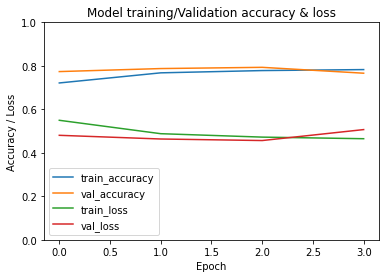

In [ ]:
# Model Validation
plt.plot(history_rnn.history['accuracy'], label='train_accuracy')
plt.plot(history_rnn.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history_rnn.history['loss'], label='train_loss')
plt.plot(history_rnn.history['val_loss'], label = 'val_loss')
plt.title('Model training/Validation accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.show()

#### Model Evaluation

In [ ]:
# predicting the sentiment on the validation data
y_hat_rnn = model_rnn.predict([X_valid_pad, X_valid['Category']])
y_pred_rnn = np.argmax(y_hat_rnn, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.87      0.81     19975
           1       0.84      0.72      0.78     19976

    accuracy                           0.79     39951
   macro avg       0.80      0.79      0.79     39951
weighted avg       0.80      0.79      0.79     39951


 Accuracy Score: 79.32

 Precision Score: 84.39

 Recall Score: 71.95

 f1_score: 77.67

 Error: 0.21

 Confusion Matrix 
 [[17316  2659]
 [ 5604 14372]]


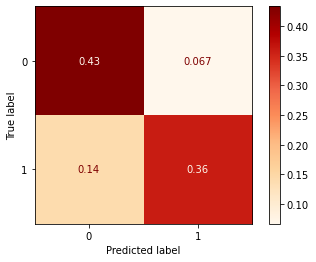

In [ ]:
# printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_rnn))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_rnn) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_rnn)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_rnn)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_rnn)* 100))

# Calculating Error
cm_rnn = confusion_matrix(y_true,y_pred_rnn)
Err_rnn = (cm_rnn[1][0]+cm_rnn[0][1])/(cm_rnn[0][0] + cm_rnn[0][1] + cm_rnn[1][0] + cm_rnn[1][1])
print('\n Error: {:.2f}'.format(Err_rnn))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_rnn)))

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred_rnn, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

## BiRNN with attention

In [41]:
# Defining and embedding the inputs - ReviewText and category
sequence_input = Input(shape=(maxlen,), dtype='int32')
prod_category = Input(shape=(1,))

embedding_reviews = embedding_layer(sequence_input)
embedding_category = embedding_layer(prod_category)

# BiRNN layer, Attention & Dense layers with dropout for regularisation
x, h, c = Bidirectional(SimpleRNN(256, return_sequences=True, return_state=True, dropout=0.2))(embedding_reviews)
x, _ = BahdanauAttention(256)(h, x)
x1 = Bidirectional(SimpleRNN(256, dropout=0.2))(embedding_category)

x = concatenate([x,x1])
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Output layer with activation function
outputs = Dense(2,activation='softmax')(x)

#Model Definition
model_rnn_at = tf.keras.Model([sequence_input, prod_category] , outputs)

In [42]:
# Model compilation & summary
model_rnn_at.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_rnn_at.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             35624700    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  [(None, 50, 512),   285184      ['embedding[2][0]']        

In [ ]:
# Model training
history_rnn_at = model_rnn_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                  validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 47s 71ms/step - loss: 0.4718 - accuracy: 0.7719 - val_loss: 0.4147 - val_accuracy: 0.8163
Epoch 2/15
625/625 [==============================] - 44s 70ms/step - loss: 0.4081 - accuracy: 0.8143 - val_loss: 0.3873 - val_accuracy: 0.8295
Epoch 3/15
625/625 [==============================] - 44s 70ms/step - loss: 0.3818 - accuracy: 0.8283 - val_loss: 0.3672 - val_accuracy: 0.8361
Epoch 4/15
625/625 [==============================] - 44s 70ms/step - loss: 0.3705 - accuracy: 0.8361 - val_loss: 0.3919 - val_accuracy: 0.8262
Epoch 00004: early stopping


In [ ]:
# Saving the model weights and model
model_rnn_at.save_weights('/content/drive/MyDrive/Aut_Res_Model_birnn_at_weights_1', save_format = 'h5') # 0.2 dropout
model_rnn_at.save('/content/drive/MyDrive/Aut_Res_Model_birnn_at_1' , save_format = 'h5')

In [ ]:
m = tf.keras.models.load_model('/content/drive/MyDrive/Aut_Res_Model_birnn_at', custom_objects={'BahdanauAttention': BahdanauAttention})

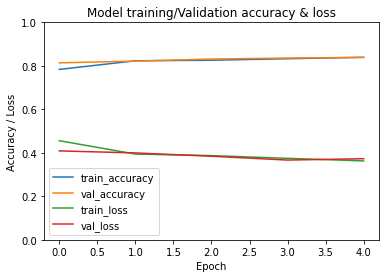

In [ ]:
# Model Validation
plt.plot(history_rnn_at.history['accuracy'], label='train_accuracy')
plt.plot(history_rnn_at.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history_rnn_at.history['loss'], label='train_loss')
plt.plot(history_rnn_at.history['val_loss'], label = 'val_loss')
plt.title('Model training/Validation accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.show()

#### Model Evaluation

In [ ]:
# predicting the sentiment on the validation data
y_hat_rnn_at = model_rnn_at.predict([X_valid_pad, X_valid['Category']])
y_pred_rnn_at = np.argmax(y_hat_rnn_at, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     19975
           1       0.83      0.84      0.84     19976

    accuracy                           0.84     39951
   macro avg       0.84      0.84      0.84     39951
weighted avg       0.84      0.84      0.84     39951


 Accuracy Score: 83.61

 Precision Score: 83.29

 Recall Score: 84.10

 f1_score: 83.69

 Error: 0.16

 Confusion Matrix 
 [[16605  3370]
 [ 3176 16800]]


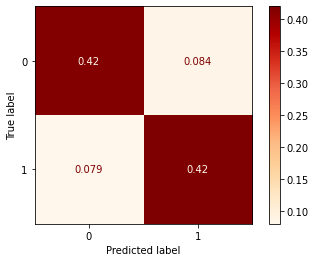

In [ ]:
#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_rnn_at))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_rnn_at) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_rnn_at)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_rnn_at)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_rnn_at)* 100))

#Calculating Error
cm_rnn_at = confusion_matrix(y_true,y_pred_rnn_at)
Err_rnn_at = (cm_rnn_at[1][0]+cm_rnn_at[0][1])/(cm_rnn_at[0][0] + cm_rnn_at[0][1] + cm_rnn_at[1][0] + cm_rnn_at[1][1])
print('\n Error: {:.2f}'.format(Err_rnn_at))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_rnn_at)))


# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred_rnn_at, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

## BiLSTM_Attention

In [43]:
# Defining and embedding the inputs - ReviewText and category
sequence_input = Input(shape=(maxlen,), dtype='int32')
prod_category = Input(shape=(1,))

embedding_reviews = embedding_layer(sequence_input)
embedding_category = embedding_layer(prod_category)

# BiLSTM layer, Attention & Dense layers with dropout
x, h_fwd, c_fwd, h_bwd, c_bwd = Bidirectional(LSTM(256, return_sequences=True, return_state=True, dropout=0.4))(embedding_reviews)
h = concatenate([h_fwd, h_bwd])
x, weights = BahdanauAttention(256)(h, x)

x1 = Bidirectional(LSTM(256, dropout=0.4))(embedding_category)
concat = concatenate([x,x1])
concat = Dense(512, activation='relu')(concat)
concat = Dropout(0.5)(concat)
concat = Dense(512, activation='relu')(concat)

# Output layer with activation function
outputs = Dense(2,activation='softmax')(concat)

#Model Definition
model_lstm_at = tf.keras.Model([sequence_input,prod_category] , outputs)

In [44]:
# Model compilation and summary
model_lstm_at.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_lstm_at.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             35624700    ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  [(None, 50, 512),   1140736     ['embedding[4][0]']              
 )                               (None, 256),                                                     
                                 (None, 256),                                               

In [ ]:
# Model training
history_lstm_at = model_lstm_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 29s 37ms/step - loss: 0.4099 - accuracy: 0.8111 - val_loss: 0.3476 - val_accuracy: 0.8455
Epoch 2/15
625/625 [==============================] - 22s 35ms/step - loss: 0.3376 - accuracy: 0.8534 - val_loss: 0.3223 - val_accuracy: 0.8574
Epoch 3/15
625/625 [==============================] - 22s 35ms/step - loss: 0.3034 - accuracy: 0.8699 - val_loss: 0.3092 - val_accuracy: 0.8667
Epoch 4/15
625/625 [==============================] - 22s 35ms/step - loss: 0.2769 - accuracy: 0.8830 - val_loss: 0.3026 - val_accuracy: 0.8713
Epoch 5/15
625/625 [==============================] - 22s 35ms/step - loss: 0.2506 - accuracy: 0.8957 - val_loss: 0.3109 - val_accuracy: 0.8716
Epoch 00005: early stopping


In [ ]:
# Saving the model weights and the model
model_lstm_at.save_weights('/content/drive/MyDrive/Aut_Res_Model_bilstm_at_weights', save_format = 'h5') # 0.2 dropout
model_lstm_at.save('/content/drive/MyDrive/Aut_Res_Model_bilstm_at', save_format='h5')

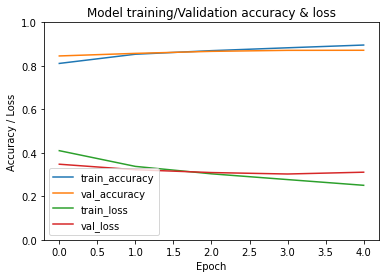

In [ ]:
# Model Validation
plt.plot(history_lstm_at.history['accuracy'], label='train_accuracy')
plt.plot(history_lstm_at.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history_lstm_at.history['loss'], label='train_loss')
plt.plot(history_lstm_at.history['val_loss'], label = 'val_loss')
plt.title('Model training/Validation accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.show()

#### Model Evaluation

In [ ]:
# predicting the sentiment on the validation data
y_hat_lstm_at = model_lstm_at.predict([X_valid_pad, X_valid['Category']])
y_pred_lstm_at = np.argmax(y_hat_lstm_at, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     19975
           1       0.87      0.87      0.87     19976

    accuracy                           0.87     39951
   macro avg       0.87      0.87      0.87     39951
weighted avg       0.87      0.87      0.87     39951


 Accuracy Score: 87.13

 Precision Score: 87.32

 Recall Score: 86.88

 f1_score: 87.10

 Error: 0.16

 Confusion Matrix 
 [[17454  2521]
 [ 2621 17355]]


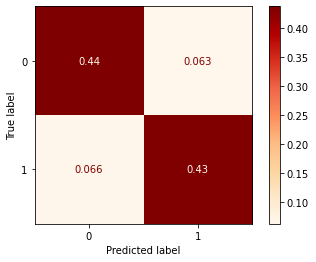

In [ ]:
#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_lstm_at))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_lstm_at) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_lstm_at)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_lstm_at)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_lstm_at)* 100))

#Calculating Error
cm_lstm_at = confusion_matrix(y_true,y_pred_rnn_at)
Err_lstm_at = (cm_lstm_at[1][0]+cm_lstm_at[0][1])/(cm_lstm_at[0][0] + cm_lstm_at[0][1] + cm_lstm_at[1][0] + cm_lstm_at[1][1])
print('\n Error: {:.2f}'.format(Err_lstm_at))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_lstm_at)))


# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred_lstm_at, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

## Bi GRU with Attention

In [45]:
# Defining and embedding the inputs - ReviewText and category
sequence_input = Input(shape=(maxlen,), dtype='int32')
prod_category = Input(shape=(1,))

embedding_reviews = embedding_layer(sequence_input)
embedding_category = embedding_layer(prod_category)

# BiGRU layer, Attention & Dense layers with dropout
x, h_fwd, h_bwd  = Bidirectional(GRU(256, return_sequences=True, return_state=True, dropout=0.2))(embedding_reviews)
h = concatenate([h_fwd, h_bwd])
x, weights = BahdanauAttention(256)(h, x)
x1 = Bidirectional(GRU(256, dropout=0.2))(embedding_category)

concat = concatenate([x,x1])
concat = Dense(512, activation='relu')(concat)
concat = Dropout(0.5)(concat)
concat = Dense(512, activation='relu')(concat)

# Output layer with activation function
outputs = Dense(2,activation='softmax')(concat)

#Model Definition
model_gru_at = tf.keras.Model([sequence_input,prod_category] , outputs)

In [46]:
# Model Compilation & Summary
model_gru_at.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_gru_at.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             35624700    ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  [(None, 50, 512),   857088      ['embedding[6][0]']              
 )                               (None, 256),                                                     
                                 (None, 256)]                                               

#### hyperparametes - various dropouts

In [ ]:
#training the model
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 49ms/step - loss: 0.3945 - accuracy: 0.8199 - val_loss: 0.3301 - val_accuracy: 0.8571
Epoch 2/15
625/625 [==============================] - 30s 47ms/step - loss: 0.3207 - accuracy: 0.8623 - val_loss: 0.3060 - val_accuracy: 0.8697
Epoch 3/15
625/625 [==============================] - 30s 47ms/step - loss: 0.2808 - accuracy: 0.8820 - val_loss: 0.3102 - val_accuracy: 0.8658
Epoch 00003: early stopping


In [ ]:
#training the model 0.1
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4011 - accuracy: 0.8156 - val_loss: 0.3373 - val_accuracy: 0.8532
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3258 - accuracy: 0.8587 - val_loss: 0.3193 - val_accuracy: 0.8624
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2906 - accuracy: 0.8772 - val_loss: 0.2998 - val_accuracy: 0.8724
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2559 - accuracy: 0.8938 - val_loss: 0.2995 - val_accuracy: 0.8744
Epoch 5/15
625/625 [==============================] - 30s 49ms/step - loss: 0.2196 - accuracy: 0.9105 - val_loss: 0.3165 - val_accuracy: 0.8717
Epoch 00005: early stopping


In [ ]:
#training the model 0.2
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 38s 51ms/step - loss: 0.4118 - accuracy: 0.8089 - val_loss: 0.3505 - val_accuracy: 0.8501
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.3119 - val_accuracy: 0.8646
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3009 - accuracy: 0.8714 - val_loss: 0.3088 - val_accuracy: 0.8679
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2729 - accuracy: 0.8859 - val_loss: 0.2938 - val_accuracy: 0.8761
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2449 - accuracy: 0.8991 - val_loss: 0.3045 - val_accuracy: 0.8757
Epoch 00005: early stopping


In [ ]:
#training the model 0.3 - good
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4130 - accuracy: 0.8091 - val_loss: 0.3445 - val_accuracy: 0.8517
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3426 - accuracy: 0.8502 - val_loss: 0.3114 - val_accuracy: 0.8662
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3097 - accuracy: 0.8671 - val_loss: 0.3025 - val_accuracy: 0.8711
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2845 - accuracy: 0.8795 - val_loss: 0.2967 - val_accuracy: 0.8741
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2633 - accuracy: 0.8903 - val_loss: 0.2967 - val_accuracy: 0.8771
Epoch 6/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2393 - accuracy: 0.9005 - val_loss: 0.3023 - val_accuracy: 0.8770
Epoch 00006: early stopping


In [ ]:
#training the model 0.4 -- good
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4237 - accuracy: 0.8018 - val_loss: 0.3453 - val_accuracy: 0.8471
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3525 - accuracy: 0.8446 - val_loss: 0.3169 - val_accuracy: 0.8635
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3234 - accuracy: 0.8611 - val_loss: 0.3032 - val_accuracy: 0.8707
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2994 - accuracy: 0.8717 - val_loss: 0.2946 - val_accuracy: 0.8752
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2813 - accuracy: 0.8804 - val_loss: 0.2924 - val_accuracy: 0.8765
Epoch 6/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2629 - accuracy: 0.8890 - val_loss: 0.3207 - val_accuracy: 0.8689
Epoch 00006: early stopping


In [ ]:
#training the model 0.3 dense dropout 0.3
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4128 - accuracy: 0.8074 - val_loss: 0.3495 - val_accuracy: 0.8475
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3397 - accuracy: 0.8510 - val_loss: 0.3129 - val_accuracy: 0.8680
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3072 - accuracy: 0.8679 - val_loss: 0.2994 - val_accuracy: 0.8731
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2824 - accuracy: 0.8806 - val_loss: 0.2931 - val_accuracy: 0.8755
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2585 - accuracy: 0.8917 - val_loss: 0.2992 - val_accuracy: 0.8764
Epoch 00005: early stopping


In [ ]:
#training the model 0.3 dense dropout 0.4
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4102 - accuracy: 0.8090 - val_loss: 0.3454 - val_accuracy: 0.8519
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3412 - accuracy: 0.8505 - val_loss: 0.3117 - val_accuracy: 0.8671
Epoch 3/15
625/625 [==============================] - 31s 50ms/step - loss: 0.3094 - accuracy: 0.8671 - val_loss: 0.3033 - val_accuracy: 0.8710
Epoch 4/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2853 - accuracy: 0.8797 - val_loss: 0.2939 - val_accuracy: 0.8756
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2611 - accuracy: 0.8904 - val_loss: 0.2979 - val_accuracy: 0.8767
Epoch 00005: early stopping


In [ ]:
#training the model 0.4 dense dropout 0.2
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4177 - accuracy: 0.8054 - val_loss: 0.3401 - val_accuracy: 0.8499
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3473 - accuracy: 0.8472 - val_loss: 0.3126 - val_accuracy: 0.8659
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3183 - accuracy: 0.8623 - val_loss: 0.3019 - val_accuracy: 0.8717
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2954 - accuracy: 0.8735 - val_loss: 0.2951 - val_accuracy: 0.8754
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2766 - accuracy: 0.8828 - val_loss: 0.3003 - val_accuracy: 0.8730
Epoch 00005: early stopping


In [ ]:
#training the model 0.4 dense dropout 0.3
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 39s 51ms/step - loss: 0.4187 - accuracy: 0.8055 - val_loss: 0.3581 - val_accuracy: 0.8425
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3510 - accuracy: 0.8459 - val_loss: 0.3173 - val_accuracy: 0.8645
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3191 - accuracy: 0.8623 - val_loss: 0.3029 - val_accuracy: 0.8713
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2962 - accuracy: 0.8743 - val_loss: 0.2947 - val_accuracy: 0.8753
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2779 - accuracy: 0.8827 - val_loss: 0.2991 - val_accuracy: 0.8776
Epoch 00005: early stopping


In [ ]:
#training the model 0.4 dense dropout 0.4 - good
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 38s 52ms/step - loss: 0.4223 - accuracy: 0.8021 - val_loss: 0.3518 - val_accuracy: 0.8418
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3508 - accuracy: 0.8455 - val_loss: 0.3152 - val_accuracy: 0.8644
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3214 - accuracy: 0.8608 - val_loss: 0.3121 - val_accuracy: 0.8637
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2979 - accuracy: 0.8725 - val_loss: 0.3032 - val_accuracy: 0.8729
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2791 - accuracy: 0.8817 - val_loss: 0.2959 - val_accuracy: 0.8775
Epoch 6/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2611 - accuracy: 0.8900 - val_loss: 0.2976 - val_accuracy: 0.8782
Epoch 00006: early stopping


In [ ]:
#training the model 0.4 dense dropout 0.5
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 52ms/step - loss: 0.4222 - accuracy: 0.8028 - val_loss: 0.3487 - val_accuracy: 0.8441
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3527 - accuracy: 0.8451 - val_loss: 0.3222 - val_accuracy: 0.8602
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3226 - accuracy: 0.8612 - val_loss: 0.3039 - val_accuracy: 0.8692
Epoch 4/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3000 - accuracy: 0.8721 - val_loss: 0.3008 - val_accuracy: 0.8731
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2817 - accuracy: 0.8805 - val_loss: 0.2947 - val_accuracy: 0.8752
Epoch 6/15
625/625 [==============================] - 31s 49ms/step - loss: 0.2634 - accuracy: 0.8894 - val_loss: 0.2960 - val_accuracy: 0.8779
Epoch 00006: early stopping


In [ ]:
#training the model 0.3 dense dropout 0.5 dense 1024
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 37s 51ms/step - loss: 0.4156 - accuracy: 0.8060 - val_loss: 0.3501 - val_accuracy: 0.8456
Epoch 2/15
625/625 [==============================] - 31s 50ms/step - loss: 0.3379 - accuracy: 0.8527 - val_loss: 0.3153 - val_accuracy: 0.8639
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.3073 - accuracy: 0.8690 - val_loss: 0.3070 - val_accuracy: 0.8715
Epoch 4/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2842 - accuracy: 0.8805 - val_loss: 0.2974 - val_accuracy: 0.8745
Epoch 5/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2609 - accuracy: 0.8913 - val_loss: 0.2961 - val_accuracy: 0.8751
Epoch 6/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2366 - accuracy: 0.9020 - val_loss: 0.2998 - val_accuracy: 0.8780
Epoch 00006: early stopping


In [ ]:
#training the model 0.4 dense dropout 0.5 dense 1024
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 39s 52ms/step - loss: 0.4183 - accuracy: 0.8060 - val_loss: 0.3458 - val_accuracy: 0.8476
Epoch 2/15
625/625 [==============================] - 31s 50ms/step - loss: 0.3502 - accuracy: 0.8467 - val_loss: 0.3211 - val_accuracy: 0.8638
Epoch 3/15
625/625 [==============================] - 31s 50ms/step - loss: 0.3208 - accuracy: 0.8615 - val_loss: 0.3008 - val_accuracy: 0.8700
Epoch 4/15
625/625 [==============================] - 31s 50ms/step - loss: 0.3004 - accuracy: 0.8723 - val_loss: 0.2945 - val_accuracy: 0.8760
Epoch 5/15
625/625 [==============================] - 31s 50ms/step - loss: 0.2807 - accuracy: 0.8809 - val_loss: 0.2988 - val_accuracy: 0.8733
Epoch 00005: early stopping


In [ ]:
model_gru_at.save_weights('/content/drive/MyDrive/Aut_Res_Model_bigru_at_weights', save_format = 'h5')
model_gru_at.save('/content/drive/MyDrive/Aut_Res_Model_bigru_at', save_format='h5')

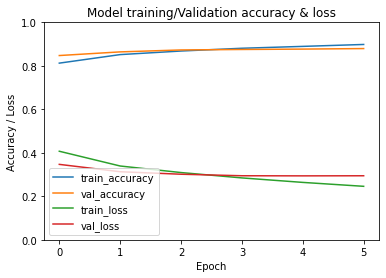

In [ ]:
# Model Validation
plt.plot(history_gru_at.history['accuracy'], label='train_accuracy')
plt.plot(history_gru_at.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history_gru_at.history['loss'], label='train_loss')
plt.plot(history_gru_at.history['val_loss'], label = 'val_loss')
plt.title('Model training/Validation accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.show()

#### hyper paramaters - various lstm units

In [ ]:
#training the model - 0.2 dense dropuout 0.5 lstm units 64
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 18s 18ms/step - loss: 0.4144 - accuracy: 0.8075 - val_loss: 0.3589 - val_accuracy: 0.8401
Epoch 2/15
625/625 [==============================] - 10s 16ms/step - loss: 0.3482 - accuracy: 0.8475 - val_loss: 0.3263 - val_accuracy: 0.8564
Epoch 3/15
625/625 [==============================] - 10s 16ms/step - loss: 0.3226 - accuracy: 0.8605 - val_loss: 0.3161 - val_accuracy: 0.8626
Epoch 4/15
625/625 [==============================] - 10s 16ms/step - loss: 0.3025 - accuracy: 0.8711 - val_loss: 0.3102 - val_accuracy: 0.8671
Epoch 5/15
625/625 [==============================] - 10s 16ms/step - loss: 0.2876 - accuracy: 0.8779 - val_loss: 0.3053 - val_accuracy: 0.8686
Epoch 6/15
625/625 [==============================] - 10s 16ms/step - loss: 0.2757 - accuracy: 0.8832 - val_loss: 0.3060 - val_accuracy: 0.8687
Epoch 00006: early stopping


In [ ]:
#training the model - 0.2 dense dropuout 0.5 lstm units 128
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 128, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 19s 22ms/step - loss: 0.4101 - accuracy: 0.8114 - val_loss: 0.3473 - val_accuracy: 0.8474
Epoch 2/15
625/625 [==============================] - 13s 20ms/step - loss: 0.3412 - accuracy: 0.8506 - val_loss: 0.3376 - val_accuracy: 0.8519
Epoch 3/15
625/625 [==============================] - 12s 20ms/step - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3220 - val_accuracy: 0.8582
Epoch 4/15
625/625 [==============================] - 12s 20ms/step - loss: 0.2907 - accuracy: 0.8767 - val_loss: 0.3012 - val_accuracy: 0.8716
Epoch 5/15
625/625 [==============================] - 12s 20ms/step - loss: 0.2710 - accuracy: 0.8865 - val_loss: 0.3033 - val_accuracy: 0.8708
Epoch 00005: early stopping


In [ ]:
# predicting the sentiment on the validation data
y_hat_gru_at = model_gru_at.predict([X_valid_pad, X_valid['Category']])
y_pred_gru_at = np.argmax(y_hat_gru_at, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)

#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_gru_at))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_gru_at) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_gru_at)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_gru_at)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_gru_at)* 100))

#Calculating Error
cm_gru_at = confusion_matrix(y_true,y_pred_rnn_at)
Err_gru_at = (cm_gru_at[1][0]+cm_gru_at[0][1])/(cm_gru_at[0][0] + cm_gru_at[0][1] + cm_gru_at[1][0] + cm_gru_at[1][1])
print('\n Error: {:.2f}'.format(Err_gru_at))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_gru_at)))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     19975
           1       0.87      0.88      0.87     19976

    accuracy                           0.87     39951
   macro avg       0.87      0.87      0.87     39951
weighted avg       0.87      0.87      0.87     39951


 Accuracy Score: 87.16

 Precision Score: 86.71

 Recall Score: 87.78

 f1_score: 87.24

 Error: 0.16

 Confusion Matrix 
 [[17288  2687]
 [ 2441 17535]]


In [ ]:
#training the model - 0.2 dense dropuout 0.5 lstm units 256
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 25s 32ms/step - loss: 0.4093 - accuracy: 0.8109 - val_loss: 0.3456 - val_accuracy: 0.8458
Epoch 2/15
625/625 [==============================] - 19s 30ms/step - loss: 0.3381 - accuracy: 0.8524 - val_loss: 0.3188 - val_accuracy: 0.8602
Epoch 3/15
625/625 [==============================] - 19s 30ms/step - loss: 0.3044 - accuracy: 0.8700 - val_loss: 0.3094 - val_accuracy: 0.8683
Epoch 4/15
625/625 [==============================] - 19s 30ms/step - loss: 0.2785 - accuracy: 0.8826 - val_loss: 0.3013 - val_accuracy: 0.8723
Epoch 5/15
625/625 [==============================] - 19s 30ms/step - loss: 0.2495 - accuracy: 0.8962 - val_loss: 0.3028 - val_accuracy: 0.8713
Epoch 00005: early stopping


In [ ]:
# predicting the sentiment on the validation data
y_hat_gru_at = model_gru_at.predict([X_valid_pad, X_valid['Category']])
y_pred_gru_at = np.argmax(y_hat_gru_at, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)

#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_gru_at))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_gru_at) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_gru_at)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_gru_at)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_gru_at)* 100))

#Calculating Error
cm_gru_at = confusion_matrix(y_true,y_pred_rnn_at)
Err_gru_at = (cm_gru_at[1][0]+cm_gru_at[0][1])/(cm_gru_at[0][0] + cm_gru_at[0][1] + cm_gru_at[1][0] + cm_gru_at[1][1])
print('\n Error: {:.2f}'.format(Err_gru_at))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_gru_at)))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     19975
           1       0.88      0.87      0.87     19976

    accuracy                           0.87     39951
   macro avg       0.87      0.87      0.87     39951
weighted avg       0.87      0.87      0.87     39951


 Accuracy Score: 87.23

 Precision Score: 87.77

 Recall Score: 86.50

 f1_score: 87.13

 Error: 0.16

 Confusion Matrix 
 [[17568  2407]
 [ 2696 17280]]


In [ ]:
#training the model - 0.4 dense dropuout 0.5 lstm units 1024
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 158s 242ms/step - loss: 0.4243 - accuracy: 0.8038 - val_loss: 0.3701 - val_accuracy: 0.8440
Epoch 2/15
625/625 [==============================] - 150s 240ms/step - loss: 0.3554 - accuracy: 0.8443 - val_loss: 0.3255 - val_accuracy: 0.8591
Epoch 3/15
625/625 [==============================] - 150s 240ms/step - loss: 0.3230 - accuracy: 0.8601 - val_loss: 0.3059 - val_accuracy: 0.8682
Epoch 4/15
625/625 [==============================] - 150s 240ms/step - loss: 0.2935 - accuracy: 0.8755 - val_loss: 0.2972 - val_accuracy: 0.8751
Epoch 5/15
625/625 [==============================] - 150s 240ms/step - loss: 0.2775 - accuracy: 0.8859 - val_loss: 0.2960 - val_accuracy: 0.8753
Epoch 6/15
625/625 [==============================] - 150s 240ms/step - loss: 0.2355 - accuracy: 0.9026 - val_loss: 0.3015 - val_accuracy: 0.8757
Epoch 00006: early stopping


### Model Training

In [ ]:
# Model training - 0.2 dropout
history_gru_at = model_gru_at.fit([X_train_pad, X_train['Category']], y_train, epochs = 15, batch_size = 256, 
                                    validation_data=([X_valid_pad, X_valid['Category']], y_valid), callbacks=es)

Epoch 1/15
625/625 [==============================] - 26s 32ms/step - loss: 0.4167 - accuracy: 0.8062 - val_loss: 0.3611 - val_accuracy: 0.8435
Epoch 2/15
625/625 [==============================] - 19s 30ms/step - loss: 0.3403 - accuracy: 0.8512 - val_loss: 0.3191 - val_accuracy: 0.8610
Epoch 3/15
625/625 [==============================] - 19s 30ms/step - loss: 0.3055 - accuracy: 0.8702 - val_loss: 0.3161 - val_accuracy: 0.8642
Epoch 4/15
625/625 [==============================] - 19s 30ms/step - loss: 0.2780 - accuracy: 0.8830 - val_loss: 0.3066 - val_accuracy: 0.8694
Epoch 5/15
625/625 [==============================] - 19s 30ms/step - loss: 0.2510 - accuracy: 0.8959 - val_loss: 0.3063 - val_accuracy: 0.8717
Epoch 6/15
625/625 [==============================] - 19s 30ms/step - loss: 0.2211 - accuracy: 0.9100 - val_loss: 0.3160 - val_accuracy: 0.8712
Epoch 00006: early stopping


In [ ]:
#Saving model and model weights
model_gru_at.save_weights('/content/drive/MyDrive/Aut_Res_Model_bigru_at_weights_2', save_format = 'h5') # 0.2 dropout
model_gru_at.save('/content/drive/MyDrive/Aut_Res_Model_bigru_at_2', save_format='h5')

#### Model Evaluation - 0.2 dropout

In [ ]:
# predicting the sentiment on the validation data
y_hat_gru_at = model_gru_at.predict([X_valid_pad, X_valid['Category']])
y_pred_gru_at = np.argmax(y_hat_gru_at, axis =1)
y_true = np.argmax(np.array(y_valid), axis=1)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     19975
           1       0.88      0.86      0.87     19976

    accuracy                           0.87     39951
   macro avg       0.87      0.87      0.87     39951
weighted avg       0.87      0.87      0.87     39951


 Accuracy Score: 87.17

 Precision Score: 87.70

 Recall Score: 86.48

 f1_score: 87.09

 Error: 0.16

 Confusion Matrix 
 [[17551  2424]
 [ 2700 17276]]


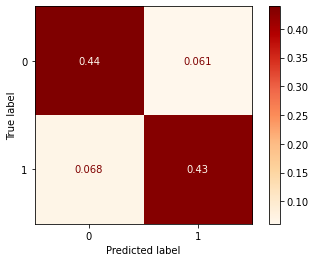

In [ ]:
#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred_gru_at))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred_gru_at) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred_gru_at)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred_gru_at)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred_gru_at)* 100))

#Calculating Error
cm_gru_at = confusion_matrix(y_true,y_pred_rnn_at)
Err_gru_at = (cm_gru_at[1][0]+cm_gru_at[0][1])/(cm_gru_at[0][0] + cm_gru_at[0][1] + cm_gru_at[1][0] + cm_gru_at[1][1])
print('\n Error: {:.2f}'.format(Err_gru_at))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred_gru_at)))


# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred_gru_at, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

## Other Algorithms

### Naive Bayes

In [47]:
#Fitting the model
nb = GaussianNB()

# Train the model using the training sets
nb.fit(X_train_pad, y_train1)

# Make predictions using the testing set
y_pred_nb = nb.predict(X_valid_pad)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.14      0.23     19951
           1       0.51      0.90      0.65     19960

    accuracy                           0.52     39911
   macro avg       0.55      0.52      0.44     39911
weighted avg       0.55      0.52      0.44     39911


 Training Accuracy Score: 0.5182

 Validation Accuracy Score: 0.5200

 Precision Score: 0.5114

 Recall Score: 0.8988

 f1_score: 0.6519

 Error: 0.4800

 Confusion Matrix 
 [[ 2814 17137]
 [ 2020 17940]]


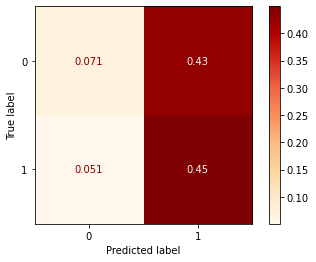

In [ ]:
#Evaluation Metrics
print('\n Classification Report: \n',classification_report(y_valid1, y_pred_nb))
print('\n Training Accuracy Score: {:.4f}'.format(nb.score(X_train_pad, y_train1)))
print('\n Validation Accuracy Score: {:.4f}'.format(accuracy_score(y_valid1, y_pred_nb)))
print('\n Precision Score: {:.4f}'.format(precision_score(y_valid1, y_pred_nb)))
print('\n Recall Score: {:.4f}'.format(recall_score(y_valid1, y_pred_nb)))
print('\n f1_score: {:.4f}'.format(f1_score(y_valid1, y_pred_nb)))

#Calculating Error
cm_nb = confusion_matrix(y_valid1, y_pred_nb)
Err_nb = (cm_nb[1][0]+cm_nb[0][1])/(cm_nb[0][0] + cm_nb[0][1] + cm_nb[1][0] + cm_nb[1][1])
print('\n Error: {:.4f}'.format(Err_nb))

print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_valid1, y_pred_nb)))

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_valid1, y_pred_nb, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

### svm

In [ ]:
svc = SVC()
svc.fit(X_train_pad, y_train1)
y_pred_svc = svc.predict(X_valid_pad)


 Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.43      0.49     19951
           1       0.55      0.69      0.61     19960

    accuracy                           0.56     39911
   macro avg       0.56      0.56      0.55     39911
weighted avg       0.56      0.56      0.55     39911


 Training Accuracy Score: 0.5827

 Validation Accuracy Score: 0.5599

 Precision Score: 0.5476

 Recall Score: 0.6905

 f1_score: 0.6108

 Error: 0.4401

 Confusion Matrix 
 [[ 8564 11387]
 [ 6178 13782]]


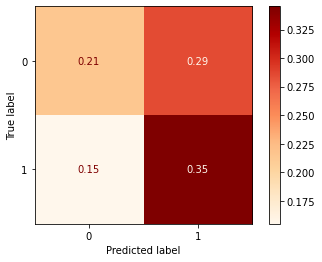

In [ ]:
#Evaluation Metrics
print('\n Classification Report: \n',classification_report(y_valid1, y_pred_svc))
print('\n Training Accuracy Score: {:.4f}'.format(svc.score(X_train_pad, y_train1)))
print('\n Validation Accuracy Score: {:.4f}'.format(accuracy_score(y_valid1, y_pred_svc)))
print('\n Precision Score: {:.4f}'.format(precision_score(y_valid1, y_pred_svc)))
print('\n Recall Score: {:.4f}'.format(recall_score(y_valid1, y_pred_svc)))
print('\n f1_score: {:.4f}'.format(f1_score(y_valid1, y_pred_svc)))
#Calculating Error
cm_svc = confusion_matrix(y_valid1, y_pred_svc)
Err_svc = (cm_svc[1][0]+cm_svc[0][1])/(cm_svc[0][0] + cm_svc[0][1] + cm_svc[1][0] + cm_svc[1][1])
print('\n Error: {:.4f}'.format(Err_svc))


print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_valid1, y_pred_svc)))

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_valid1, y_pred_svc, normalize='all')).plot(cmap=plt.cm.OrRd)
plt.grid(False)

## Predicting sentiment and generating response for test data

In [ ]:
#reading the test data which is unseen by the model
df_test = pd.read_csv("/content/drive/MyDrive/Amazon_Reviews_test.csv", index_col=0)

In [ ]:
response_pos = "Dear Customer, Thank you for your review. We are very glad that you are satisfied with our product. Your satisfaction is our ultimate goal. Looking forward to your next visit"
response_neg = "Dear Customer, we are very sorry for the inconvinience caused. We suggest you to contact our customer service and we will be happy to help you further."

In [ ]:
df_test.sample()

,reviewText,overall,Category
737,"I find this size perfect for my use, since I cook for one and 1/2 (my little dog) and it is small enough so that my leftovers don't grow beards before they're gone.",1,HomeKitchen


In [ ]:
X_test = df_test[['reviewText', 'Category']]
y_test = df_test['overall']

In [ ]:
#applying text pre-processing on the test data
X_test['reviewText'] = X_test['reviewText'].apply(lambda x: str(x).lower())
X_test['reviewText'] = X_test['reviewText'].apply(lambda x: expand_words(x))
X_test['reviewText'] = X_test['reviewText'].apply(lambda x: remove_special_characters(x))
X_test['reviewText'] = X_test['reviewText'].apply(lambda x: remove_accented_chars(x))
X_test['reviewText'] = X_test['reviewText'].apply(lambda x: remove_stopwords(x))

In [ ]:
lb = LabelEncoder()
X_test['Category'] = lb.fit_transform(X_test['Category'])
y_test = lb.fit_transform(y_test)

In [ ]:
# tokenizing and padding the test data
#defining the tokenizer
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(df_test['reviewText'].astype("str"))

X_test_seq = tokenizer_test.texts_to_sequences(X_test['reviewText'].astype("str"))
X_test_pad = pad_sequences(X_test_seq, maxlen=int(maxlen), padding='post')
maxlen = 50

In [ ]:
#predicting the is_sarcastic label on the validation data
y_hat_test = model_gru_at.predict([X_test_pad, X_test['Category']])
y_pred_test = np.argmax(y_hat_test, axis =1)
y_true_test = y_test

In [ ]:
# applying the trained model on the test data and the predictions are saved as a pandas series
df_test['prediction'] = y_pred_test
df_test['response'] = df_test['prediction'] .replace(0, response_neg).replace(1, response_pos)

In [ ]:
results = pd.DataFrame(columns=['category', 'actual positives',	'predicted positives',	'actual negatives',	'predicted negatives'])

for i, category in enumerate(df_test['Category'].unique()):
  df_test_ = df_test[df_test['Category'] == category].reset_index(drop=True)
  ap = df_test_[df_test_['overall'] == 1]['overall'].count()
  pp = df_test_[df_test_['prediction'] == 1]['prediction'].count()
  an = df_test_[df_test_['overall'] == 0]['overall'].count()
  pn = df_test_[df_test_['prediction'] == 0]['prediction'].count()
  results.loc[i, :] = [category, ap,pp,an,pn]
  print(results)


,category,actual positives,predicted positives,actual negatives,predicted negatives
0,Beauty,100,97,100,103
1,Electronics,100,99,100,101
2,Fashion,100,95,100,105
3,HomeKitchen,100,104,100,96
4,ToysGames,100,70,100,130


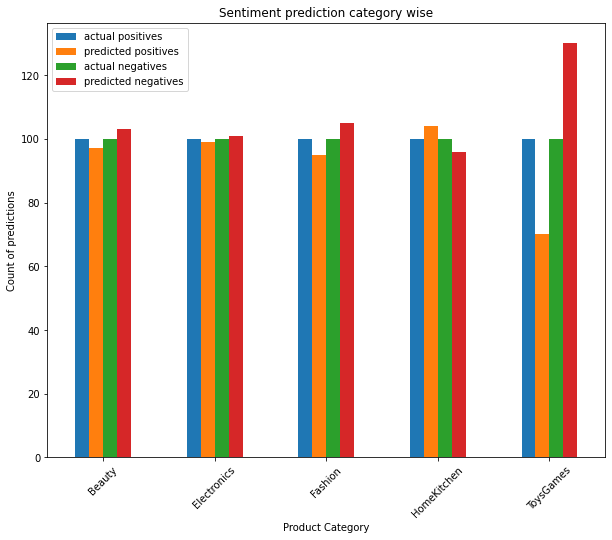

In [ ]:
# plot grouped bar chart
barplot = results.plot(x='category',
        kind='bar',
        stacked=False,
        title='Sentiment prediction category wise',
        xlabel = 'Product Category',
        ylabel = "Count of predictions", rot = 45,
        figsize = (10,8))

barplot.legend(loc=2)

In [ ]:
for i, row in df_test.sample(10).iterrows():
  print("\nReview :", row['reviewText'])
  print("\nResponse :", row['response'])


Review : The display is easy to see and all of the functions seem to work well. Don't expect this watch to be slim. It is a thick watch. This is OK by me as I only use it for workouts and not an everyday watch. It was everything I expected it to be.

Response : Dear Customer, Thank you for your review. We are very glad that you are satisfied with our product. Your satisfaction is our ultimate goal. Looking forward to your next visit

Review : This is my first review to post..on anything!!! I took the time to say two things- these pads are so wonderful, and I think (with sunblock) contribute to great skin! I am very fair, sensitive and I absolutely love these! They make my skin look radiant, and helps with oil/pores. As a mom of a toddler, I am on a limited budget, but these pads are my essential! I have compromised other skin care products, like cleansers and moisterizers, but this is my only must!!

Response : Dear Customer, Thank you for your review. We are very glad that you are sa

In [ ]:
df_test.sample(20)

,reviewText,overall,Category,prediction,response
167,I started using this product a few weeks ago a...,1,Beauty,1,"Dear Customer, Thank you for your review. We a..."
386,I was on youtube and saw an add for this item....,1,Electronics,1,"Dear Customer, Thank you for your review. We a..."
844,We agree with Wendy - don't waste your money. ...,0,ToysGames,0,"Dear Customer, we are very sorry for the incon..."
393,"I was pretty skeptical at first, but after usi...",1,Electronics,1,"Dear Customer, Thank you for your review. We a..."
26,I bought this product at my local HEB and was ...,0,Beauty,0,"Dear Customer, we are very sorry for the incon..."
384,"Great at cleaning finger prints, water stains,...",1,Electronics,1,"Dear Customer, Thank you for your review. We a..."
838,This model was shown at a huge discount and a ...,0,ToysGames,0,"Dear Customer, we are very sorry for the incon..."
942,A MUST HAVE toy for both boys and girls alike!...,1,ToysGames,0,"Dear Customer, we are very sorry for the incon..."
267,I wear glasses. sometime when I clean my glass...,0,Electronics,0,"Dear Customer, we are very sorry for the incon..."
529,This visor has saved me a lot of sunburn as we...,1,Fashion,0,"Dear Customer, we are very sorry for the incon..."
